In [2]:
# For data manipulation
import numpy as np
import pandas as pd
import yfinance as yf
#import pyfolio as pf
from hmmlearn import hmm
from sklearn.utils import check_random_state

# For data visualization
import matplotlib.pyplot as plt

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Function to create the DC indicators provided by Chen and Tsang (2021)
def directional_change_events(data, theta=0.2):

    # Copy the dataframe
    data = data.copy()

    # Create the necessary columns and variables
    data["Event"] = 0.0

    # Set the initial event variable value
    event = "upward" # initial event

    # Set the initial value for low and high prices
    ph = data['Close'].iloc[0] # highest price
    pl = data['Close'].iloc[0] # lowest price

    # Create loop to run through each date
    for t in range(0, len(data.index)):
        # Check if we're on a downward trend
        if event == "downward":
            # Check if the close price is higher than the low price by the theta threshold
            if data["Close"].iloc[t] >= pl * (1 + theta):
                # Set the event variable to upward
                event = "upward"
                # Set the high price as the current close price
                ph = data["Close"].iloc[t]
            # If the close price is lower than the low price by the theta threshold
            else:
                # Check if the close price is less than the low price
                if data["Close"].iloc[t] < pl:
                    # Set the low price as the current close price
                    pl = data["Close"].iloc[t]
                    # Set the Event to upward for the current period
                    data["Event"].iloc[t] = 1
        # Check if we're on a upward trend
        elif event == "upward":
            # Check if the close price is less than the high price by the theta threshold
            if data["Close"].iloc[t] <= ph * (1 - theta):
                # Set the event variable to downward
                event = "downward"
                # Set the low price as the current close price
                pl = data["Close"].iloc[t]
            # If the close price is higher than the high price by the theta threshold
            else:
                # Check if the close price is higher than the high price
                if data["Close"].iloc[t] > ph:
                    # Set the high price as the current close price
                    ph = data["Close"].iloc[t]
                    # Set the Event to downward for the current period
                    data["Event"].iloc[t] = -1

    # Set the peak and trough prices and forward-fill the column
    data['peak_trough_prices'] = np.where(data['Event']!=0, data['Close'],0)
    data['peak_trough_prices'].replace(to_replace=0, method='ffill', inplace=True)

    # Count the number of periods between a peak and a trough
    data['count'] = 0
    for i in range(1,len(data.index)):
        if data['Event'].iloc[(i-1)]!=0:
            data['count'].iloc[i] = 1+data['count'].iloc[(i-1)]
        else:
            data['count'].iloc[i] = 1

    # Compute the TMV indicator
    data['TMV'] = np.where(data['Event']!=0, abs(data['peak_trough_prices']-data['peak_trough_prices'].shift())/\
                          (data['peak_trough_prices'].shift()*theta),0)

    # Compute the time-completion-for-a-trend indicator
    data['T'] = np.where(data['Event']!=0, data['count'],0)

    # Compute the time-adjusted-return indicator and forward-fill it
    data['R'] = np.where(data['Event']!=0, np.log(data['TMV']/data['T']*theta),0)
    data['R'] = data['R'].replace(to_replace=0, method='ffill')

    # Drop NaN or inifinite values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    return data

In [4]:
# Download the GBPUSD data from 2003 to 2013
data = yf.download('CADCNY=X', start='2010-12-01', end='2025-05-02', auto_adjust=True)

# Compute the log returns
data['returns'] = np.log(data['Close']/data['Close'].shift(1))

# Print the data
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,returns
Ticker,CADCNY=X,CADCNY=X,CADCNY=X,CADCNY=X,CADCNY=X,
Date,,,,,,
2010-12-01,6.506800,6.537700,6.495000,6.507800,0,NaN
2010-12-02,6.541800,6.613700,6.541300,6.546200,0,0.005365
2010-12-03,6.630700,6.645000,6.596200,6.630000,0,0.013498
2010-12-06,6.605600,6.630300,6.575100,6.606100,0,-0.003793
2010-12-07,6.586900,6.624900,6.557500,6.586200,0,-0.002835
...,...,...,...,...,...,...
2025-04-28,5.252538,5.269918,5.244882,5.252784,0,-0.000911
2025-04-29,5.273642,5.282158,5.258415,5.273070,0,0.004010


In [5]:
# Flatten MultiIndex columns
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]
print(data.columns)


Index(['Close_CADCNY=X', 'High_CADCNY=X', 'Low_CADCNY=X', 'Open_CADCNY=X',
       'Volume_CADCNY=X', 'returns_'],
      dtype='object')


In [6]:
data.rename(columns={'Close_CADCNY=X': 'Close'}, inplace=True)
data

,Close,High_CADCNY=X,Low_CADCNY=X,Open_CADCNY=X,Volume_CADCNY=X,returns_
Date,,,,,,
2010-12-01,6.506800,6.537700,6.495000,6.507800,0,NaN
2010-12-02,6.541800,6.613700,6.541300,6.546200,0,0.005365
2010-12-03,6.630700,6.645000,6.596200,6.630000,0,0.013498
2010-12-06,6.605600,6.630300,6.575100,6.606100,0,-0.003793
2010-12-07,6.586900,6.624900,6.557500,6.586200,0,-0.002835
...,...,...,...,...,...,...
2025-04-28,5.252538,5.269918,5.244882,5.252784,0,-0.000911
2025-04-29,5.273642,5.282158,5.258415,5.273070,0,0.004010
2025-04-30,5.256859,5.265884,5.247031,5.257467,0,-0.003188


In [7]:


# Compute the DC indicators
data = directional_change_events(data, theta=0.004)

# Drop NaN values
data.dropna(inplace=True)

# Present the data
data

,Close,High_CADCNY=X,Low_CADCNY=X,Open_CADCNY=X,Volume_CADCNY=X,returns_,Event,peak_trough_prices,count,TMV,T,R
Date,,,,,,,,,,,,
2010-12-03,6.630700,6.645000,6.596200,6.630000,0,0.013498,-1.0,6.630700,2,3.397386,2,-4.991602
2010-12-06,6.605600,6.630300,6.575100,6.606100,0,-0.003793,0.0,6.630700,3,0.000000,0,-4.991602
2010-12-07,6.586900,6.624900,6.557500,6.586200,0,-0.002835,0.0,6.630700,1,0.000000,0,-4.991602
2010-12-08,6.596000,6.603100,6.552600,6.596100,0,0.001381,0.0,6.630700,1,0.000000,0,-4.991602
2010-12-09,6.571600,6.595600,6.542900,6.572400,0,-0.003706,1.0,6.571600,1,2.228277,1,-4.720232
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,5.252538,5.269918,5.244882,5.252784,0,-0.000911,0.0,5.280365,1,0.000000,0,-7.001165
2025-04-29,5.273642,5.282158,5.258415,5.273070,0,0.004010,0.0,5.280365,1,0.000000,0,-7.001165
2025-04-30,5.256859,5.265884,5.247031,5.257467,0,-0.003188,0.0,5.280365,1,0.000000,0,-7.001165


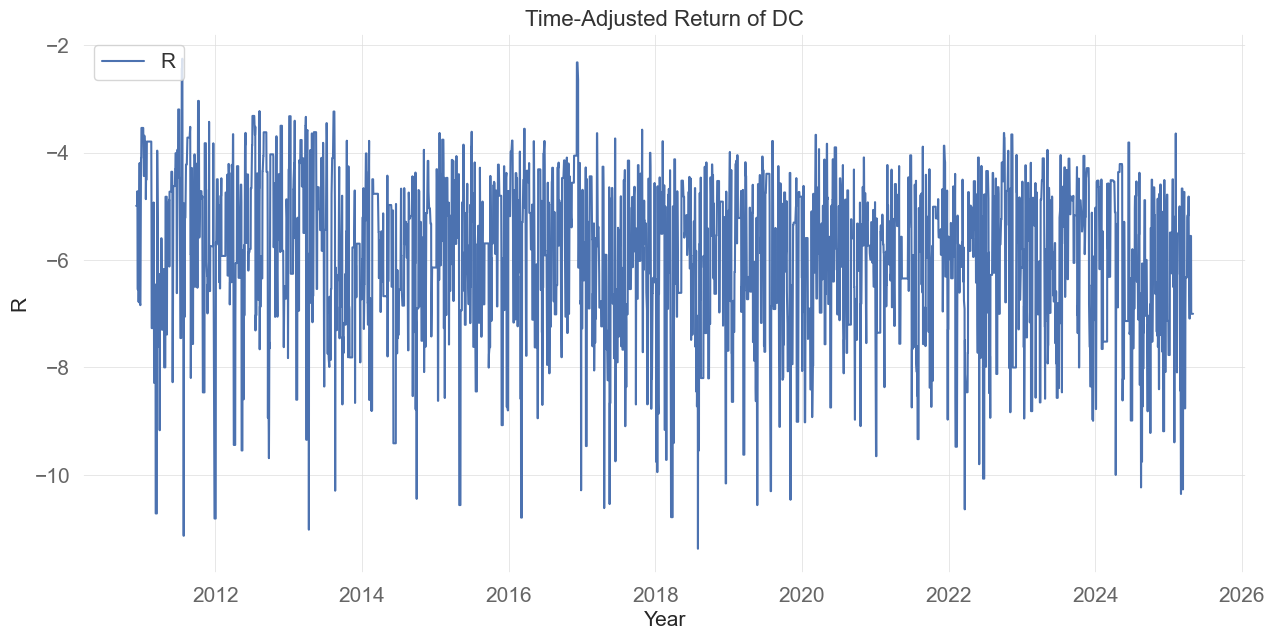

In [8]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot the R indicator
plt.plot(data.index, data['R'], label = "R")

# Set the title of the graph
plt.title('Time-Adjusted Return of DC', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('R', fontsize=15)#
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

#plt.savefig('Figures/R_time_series.png', bbox_inches='tight')
plt.show()

In [9]:
data['Event'].value_counts()

Event
 0.0    2247
-1.0     767
 1.0     742
Name: count, dtype: int64

In [10]:
model=hmm.GaussianHMM(n_components=2,covariance_type="diag",n_iter=100,random_state=42)
X=data[['R']].values
results=model.fit(X)
data['states']=results.predict(X)
data['states'].value_counts()

states
1    2219
0    1537
Name: count, dtype: int64

In [11]:
state0_R_vol=data['R'][data['states']==0].mean()

# Find the R mean for state 1
state1_R_vol = data['R'][data['states']==1].mean()

# Print the R volatility for both states
print(f'R-based volatility for state 0, 1 and 2 are {state0_R_vol:.2f} and {state1_R_vol:.2f}, respectively')

R-based volatility for state 0, 1 and 2 are -4.66 and -6.90, respectively


In [12]:
# Find the returns standard deviation for state 0
state0_vol = data['returns_'][data['states']==0].std()*np.sqrt(252)*100

# Find the returns standard deviation for state 1
state1_vol = data['returns_'][data['states']==1].std()*np.sqrt(252)*100

# Print the returns volatility for both states
print(f'Volatility for state 0 and 1 are {state0_vol:.2f} and {state1_vol:.2f}, respectively')

Volatility for state 0 and 1 are 14.77 and 9.71, respectively


In [13]:
# Set the initial day to start the trading backtesting loop
initial_t = data.index.get_loc(data.loc['2018':].index[0])

# Print the initial day
initial_t

1844

In [14]:
data['sma']=data['Close'].rolling(4).mean()

data['signal']=np.where(data['Close']>data['sma'],1,-1)

data['dc_leverage']=0
data['dc_next_state']=0


In [15]:
# # Create the backtesting loop
# for t in range(initial_t, (len(data.index)-1)):
#     # Create a data sample to be used for the trading computations
#     data_sample = data[['R','returns_']].iloc[:(t+1)]
#
#     # Create an HMM model object
#     dc_model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 200, random_state = 100)
#
#     # Create the array input to be used for the HMM model
#     dc_X = data_sample[['R']].values
#
#     # Fit the model to the data
#     dc_results = dc_model.fit(dc_X)
#
#     # Obtain the fitted hidden states for the data sample
#     data_sample['dc_states'] = dc_results.predict(dc_X)
#
#     # Compute the next state hidden state
#     dc_transmat_cdf = np.cumsum(dc_results.transmat_, axis=1)
#     dc_random_state = check_random_state(dc_results.random_state)
#     data['dc_next_state'].iloc[t] = (dc_transmat_cdf[data_sample['dc_states'].iloc[-1]] > dc_random_state.rand()).argmax()
#
#     # Compute the R volatility for each state
#     dc_state0_vol = data_sample['R'][data_sample['dc_states']==0].mean()
#     dc_state1_vol = data_sample['R'][data_sample['dc_states']==1].mean()
#
#     # Invest all capital if the forecasted regime is 0 and its volatility is higher than regime 1
#     if (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol>dc_state1_vol):
#         data['dc_leverage'].iloc[t] = 1.0
#     # Invest 2 times the capital if the forecasted regime is 0 and its volatility is lower than regime 1
#     elif (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol<dc_state1_vol):
#         data['dc_leverage'].iloc[t] = 2.0
#     # Invest 2 times the capital if the forecasted regime is 1 and its volatility is lower than regime 1
#     elif (data['dc_next_state'].iloc[t]==1) and (dc_state0_vol>dc_state1_vol):
#         data['dc_leverage'].iloc[t] = 2.0
#     # Invest all capital if the forecasted regime is 1 and its volatility is higher than regime 1
#     else:
#         data['dc_leverage'].iloc[t] = 1.0
#
# # Set the final signal to 0 to square off any open position
# data['signal'].iloc[-1] = 0.0

In [16]:
# Create the backtesting loop
for t in range(initial_t, (len(data.index)-1)):
    # Create a data sample to be used for the trading computations
    data_sample = data[['R','returns_']].iloc[:(t+1)]

    # Create an HMM model object
    dc_model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 200, random_state = 100)

    # Create the array input to be used for the HMM model
    dc_X = data_sample[['R']].values

    # Fit the model to the data
    dc_results = dc_model.fit(dc_X)

    # Obtain the fitted hidden states for the data sample
    data_sample['dc_states'] = dc_results.predict(dc_X)

    # Compute the next state hidden state
    dc_transmat_cdf = np.cumsum(dc_results.transmat_, axis=1)
    dc_random_state = check_random_state(dc_results.random_state)
    data['dc_next_state'].iloc[t] = (dc_transmat_cdf[data_sample['dc_states'].iloc[-1]] > dc_random_state.rand()).argmax()

    # Compute the R volatility for each state
    dc_state0_vol = data_sample['R'][data_sample['dc_states']==0].mean()
    dc_state1_vol = data_sample['R'][data_sample['dc_states']==1].mean()

    # Invest all capital if the forecasted regime is 0 and its volatility is higher than regime 1
    if (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol<dc_state1_vol):
        data['dc_leverage'].iloc[t] = 1.0
    # Invest 2 times the capital if the forecasted regime is 0 and its volatility is lower than regime 1
    elif (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol>dc_state1_vol):
        data['dc_leverage'].iloc[t] = 2.0
    # Invest 2 times the capital if the forecasted regime is 1 and its volatility is lower than regime 1
    elif (data['dc_next_state'].iloc[t]==1) and (dc_state0_vol<dc_state1_vol):
        data['dc_leverage'].iloc[t] = 2.0
    # Invest all capital if the forecasted regime is 1 and its volatility is higher than regime 1
    else:
        data['dc_leverage'].iloc[t] = 1.0

# Set the final signal to 0 to square off any open position
data['signal'].iloc[-1] = 0.0

In [17]:
# Subset the data for plotting
plot_data = data.loc['2018':]

# Count the number of days in which we face different leverages
plot_data['dc_leverage'].value_counts()

dc_leverage
1    1325
2     586
0       1
Name: count, dtype: int64

In [18]:
# Compute the Buy-and-Hold cumulative returns
plot_data['buy_hold_cum_rets'] = np.exp(plot_data['returns_'].cumsum())

# Compute the simple 4-day moving average strategy returns
plot_data['basic_stra_rets'] = plot_data['returns_']*plot_data['signal'].shift(1)

# Compute the simple 4-day moving average strategy cumulative returns
plot_data['basic_stra_cum_rets'] = np.exp(plot_data['basic_stra_rets'].cumsum())

# Compute the HMM-DC-based strategy returns
plot_data['hmm_dc_stra_rets'] = plot_data['returns_']*plot_data['signal'].shift(1)*plot_data['dc_leverage'].shift(1)

# Compute the HMM-DC-based strategy cumulative returns
plot_data['hmm_dc_stra_cum_rets'] = np.exp(plot_data['hmm_dc_stra_rets'].cumsum())

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\howie\\PycharmProjects\\quant-code\\other-strategy\\Figures\\CNY-CAD(lever up if high vol).png'

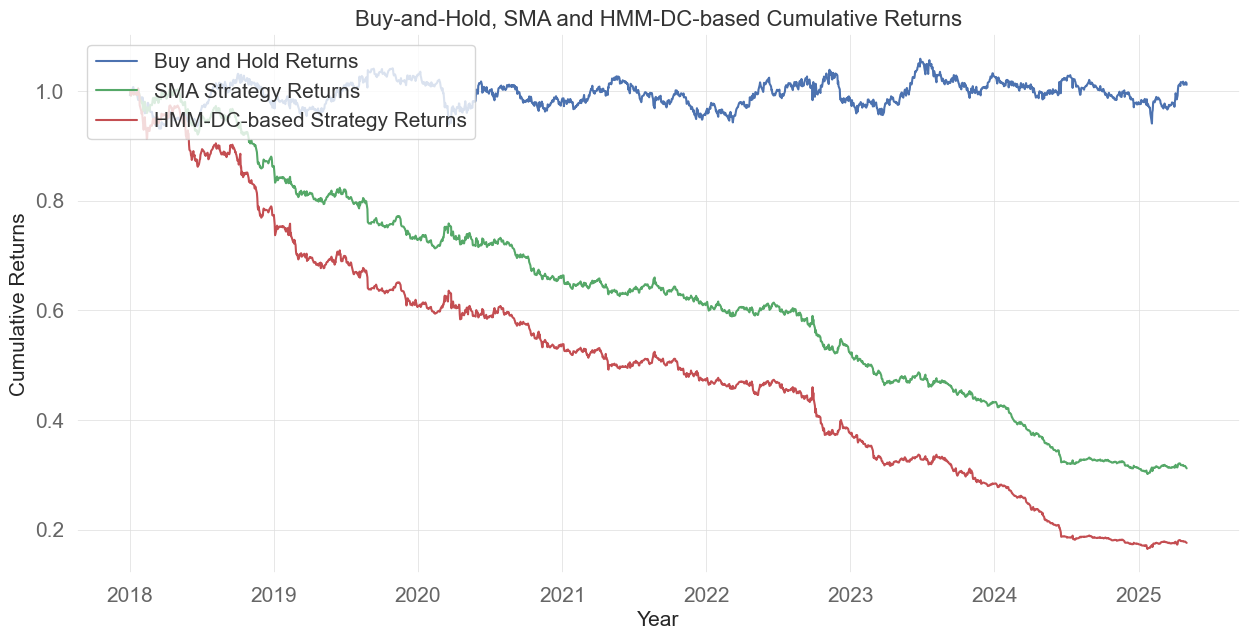

In [19]:
 # Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold, SMA and HMM-DC-based strategy cumulative returns
plt.plot(plot_data.index, plot_data['buy_hold_cum_rets'], label = "Buy and Hold Returns")
plt.plot(plot_data.index, plot_data['basic_stra_cum_rets'], label = "SMA Strategy Returns", color='g')
plt.plot(plot_data.index, plot_data['hmm_dc_stra_cum_rets'], label = "HMM-DC-based Strategy Returns", color='r')
#plt.plot(plot_data.index, plot_data['hmm_stra_cum_rets'], label = "HMM-based Strategy Returns", color='y')

# Set the title of the graph
plt.title('Buy-and-Hold, SMA and HMM-DC-based Cumulative Returns', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Cumulative Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
import os

# 检查并创建目标文件夹
output_dir = 'C:\\Users\\howie\\PycharmProjects\\quant-code\\other-strategy\\Figures'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存图像
plt.savefig(os.path.join(output_dir, 'CNY-CAD(lever up if high vol).png'), bbox_inches='tight')

In [1]:
import quantstats as qs

# Buy-and-Hold strategy
qs.reports.metrics(plot_data['buy_hold_cum_rets'].pct_change().dropna(), title="Buy and Hold")

# 4-day SMA strategy
qs.reports.metrics(plot_data['basic_stra_cum_rets'].pct_change().dropna(), title="4-day SMA")

# HMM-DC based strategy
qs.reports.metrics(plot_data['hmm_dc_stra_cum_rets'].pct_change().dropna(), title="HMM-DC + 4-day SMA")


NameError: name 'plot_data' is not defined